# Bootstrap


In [1]:
import numpy as np
#import os
#os.getcwd() 
from base import EnsembleNetwork
import dataset_creation 
import importlib
importlib.reload(dataset_creation)

#import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [15, 5]

%matplotlib inline

In [2]:
ld = dataset_creation.LinearDataset()

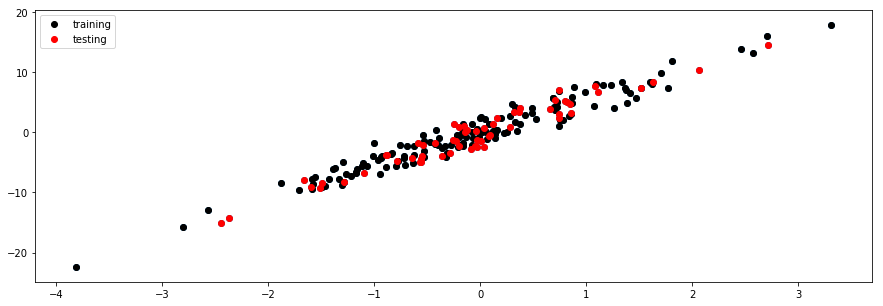

In [3]:
ld.plot_dataset()

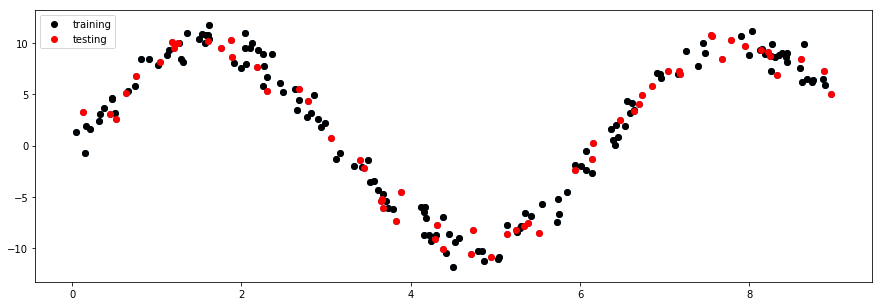

In [4]:
nd = dataset_creation.NonlinearDataset()
nd.plot_dataset()



# Bootstrap Through Time

In [37]:
from copy import copy,deepcopy
import matplotlib.pyplot as plt
import numpy as np

class BootstrapEnsemble(object):    
    def __init__(self,ensemble=None,num_features = None,num_epochs=10,num_ensembles=14):
        self.num_features = num_features or 1
        self.ensemble_list = ensemble or [EnsembleNetwork] *num_ensembles
        self.num_epochs = num_epochs
        self.initialise_ensemble()
        
    def initialise_ensemble(self):
        self.ensemble = [member(num_features=self.num_features,seed=i+42,num_epochs=self.num_epochs) for i,member in enumerate(self.ensemble_list)]
        
    def fit(self, X, y):
        '''This is where we build in the Online Bootstrap'''
        for estimator in self.ensemble:
            estimator.fit(X,y)
            
    def get_prediction_list(self,X):
        pred_list = []
        for estimator in self.ensemble:
            prediction = estimator.predict(X)
            pred_list.append(prediction)
        return pred_list
      

    def predict(self, X):
        pred_list = self.get_prediction_list(X)
        predictive_mean = np.mean(pred_list, 0)

        return predictive_mean
    
    def predict_std(self,X):

        pred_list = self.get_prediction_list(X)
        predictive_uncertainty = np.std(pred_list, 0) or 0.001
        

        return predictive_uncertainty
    
    def get_mean_and_std(self,X):
        pred_list = self.get_prediction_list(X)
        pred_mean = np.mean(pred_list,axis=0)
        pred_std = np.std(pred_list,axis=0)
        return pred_mean, pred_std
    

    def compute_rsme(self,X,y):
        y_hat = self.predict(X)
        return np.sqrt(np.mean((y_hat - y)**2))

    
class BootstrapThroughTimeBobStrap_doesntworkbecausetensorflowhasnocopymanthatssad(BootstrapEnsemble):
    
    def __init__(self,num_features = None,num_epochs = 10,num_ensembles=10):
        
        super(BootstrapThroughTimeBobStrap, self).__init__(ensemble=None,num_features = num_features,num_epochs=50,num_ensembles=1)
        self.num_epochs = num_epochs
        self.num_ensembles = num_ensembles
            
            
    @property
    def num_current_ensembles(self):
        return len(self.ensemble)
            
    def fit(self,X,y):
        error_list_self = []
        error_list_model = []
        #replace a member if it's rsme is higher than the new model. Keep new model somewhere and STILL train it, just in case it gets significantly better
        for i in range(self.num_epochs):
            for estimator in self.ensemble:
                if self.num_current_ensembles < self.num_ensembles:
                    self.ensemble.append(copy(estimator))
                    print('{} out of {} predictors ready'.format(self.num_current_ensembles,self.num_ensembles))
                    #replace the worst model with a new one
                estimator.fit(X,y)
            error_list_model.append(estimator.compute_rsme(X,y))
            error_list_self.append(self.compute_rsme(X,y))
            print(np.mean((np.array(error_list_model)-np.array(error_list_self))**2))
            

            
            
class BootstrapThroughTimeBobStrap_doesntworkbecausetensorflowhasnocopymanthatssad(BootstrapEnsemble):
    
    def __init__(self,num_features = None,num_epochs = 10,num_ensembles=10):
        
        super(BootstrapThroughTimeBobStrap, self).__init__(ensemble=None,num_features = num_features,num_epochs=50,num_ensembles=1,seed=None)
        self.num_epochs = num_epochs
        self.num_ensembles = num_ensembles
        self.seed = seed or 42
            
    def initialise_ensemble(self):
        self.ensemble = [member(num_features=self.num_features,seed=self.seed,num_epochs=self.num_epochs) for i,member in enumerate(self.ensemble_list)]
                    
    @property
    def num_current_ensembles(self):
        return len(self.ensemble)
            
    def fit(self,X,y):
        error_list_self = []
        error_list_model = []
        #replace a member if it's rsme is higher than the new model. Keep new model somewhere and STILL train it, just in case it gets significantly better
        for i in range(self.num_epochs):
            for estimator in self.ensemble:
                if self.num_current_ensembles < self.num_ensembles:
                    
                    
                    
                    
                    
                    
                    
                    
                    
                    
                    #self.ensemble.append(copy(estimator))
                    print('{} out of {} predictors ready'.format(self.num_current_ensembles,self.num_ensembles))
                    #replace the worst model with a new one
                estimator.fit(X,y)
            error_list_model.append(estimator.compute_rsme(X,y))
            error_list_self.append(self.compute_rsme(X,y))
            print(np.mean((np.array(error_list_model)-np.array(error_list_self))**2))
            

            

# Bootstrap

In [38]:
#boot = BootstrapEnsemble()

# Bootstrap Through time

In [39]:
bob = BootstrapThroughTimeBobStrap()

In [40]:
#bob.initialise_ensemble()

In [41]:
import visualisation 
importlib.reload(visualisation)

<module 'visualisation' from '/Users/thomas/Documents/Master-Thesis/new_version/visualisation.py'>

1.5657579216779042e-15
7.829478705457707e-16
5.737499334952476e-16
6.394499176966664e-16
6.511601398069655e-16
7.637963454158313e-16
7.466103777096212e-16
6.758412879896739e-16
6.513784936518501e-16
9.55543460576488e-16
1.6675779529667183e-16
3.0564176494791304e-16
6.798584112580875e-16
9.289811911128139e-16
7.995925145834487e-16
1.0212331520839927e-15
9.624915922379872e-16
9.682206532801279e-16
8.617341945102127e-16
7.763079973647834e-16
8.73710924546177e-17
2.5463490123249753e-15
2.4970252867488115e-15
2.3926492591700644e-15
2.229710490338118e-15
1.86159974689032e-15
1.595686208160345e-15
1.6124347759810122e-15
1.4594363839467456e-15
1.4664537263860638e-15


'this run of 10 epochs and 3 metaepochs took 2143.7226269245148s'

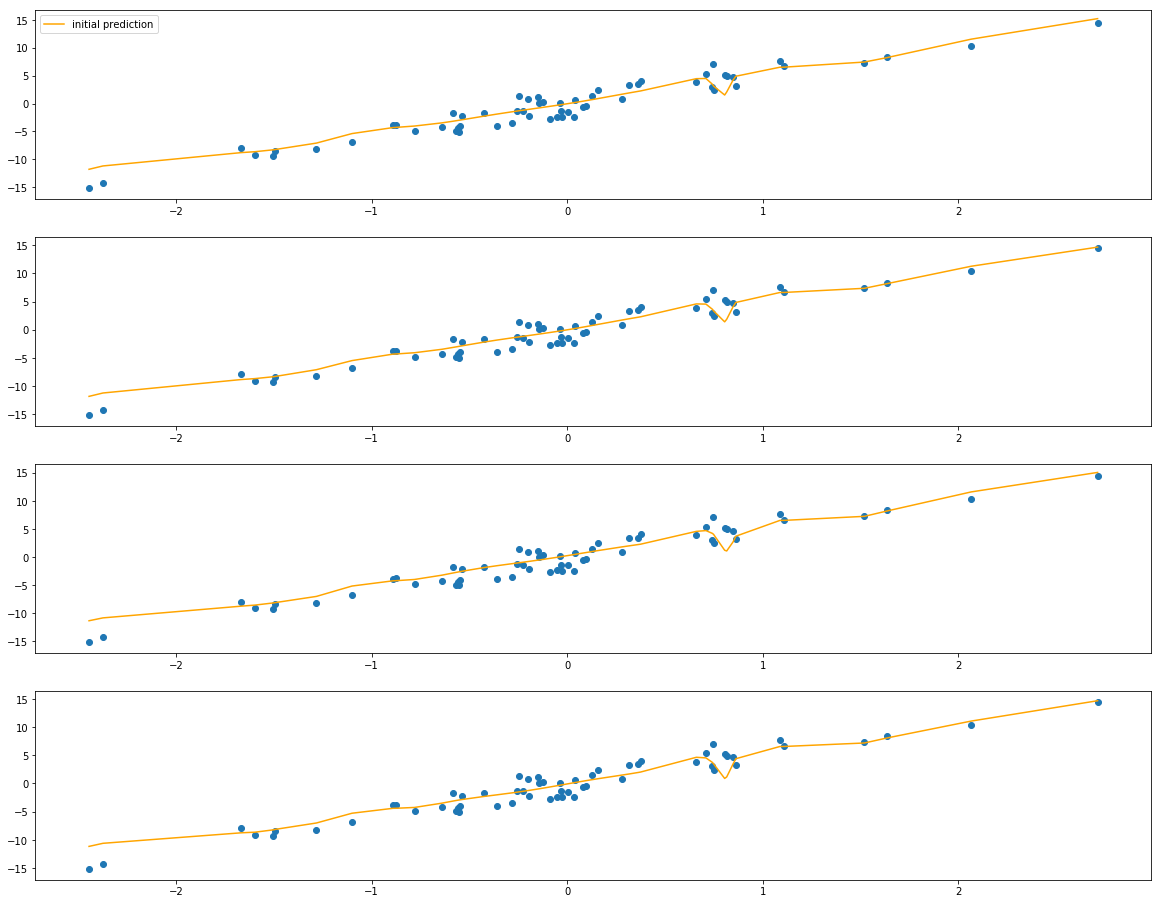

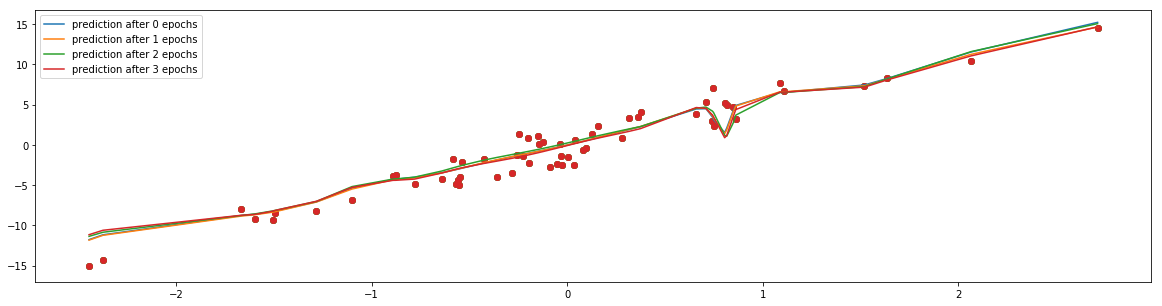

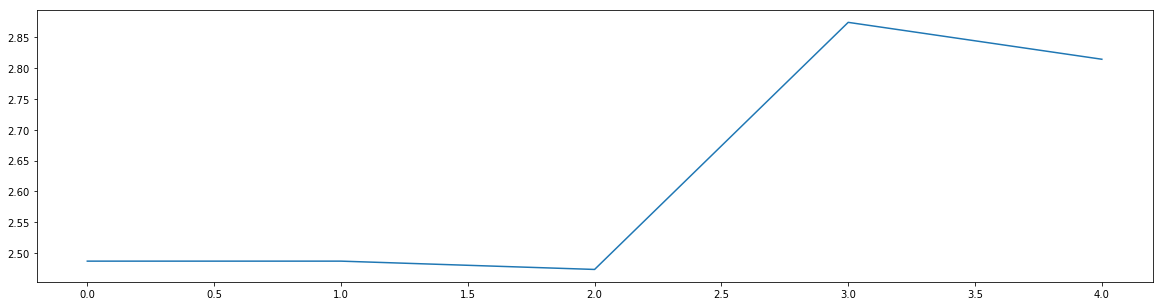

In [43]:
#net = EnsembleNetwork(num_epochs=25)#num_epochs = num_epochs,learning_rate=learning_rate,adversarial=False,num_neurons=num_neurons)
visualisation.visualise(bob,dataset_creation.LinearDataset)

2 out of 10 predictors ready
3 out of 10 predictors ready
4 out of 10 predictors ready
5 out of 10 predictors ready
6 out of 10 predictors ready
7 out of 10 predictors ready
8 out of 10 predictors ready
9 out of 10 predictors ready
10 out of 10 predictors ready
3.3677445079234544e-16
2.2256554972121596e-16
1.3938241329668424e-15
1.119824661000865e-15
1.540351833557407e-15
1.9520838820930086e-15
2.242725789553237e-15
1.98118114889617e-15
1.878410226006407e-15
1.896337329820977e-15
5.01902343781225e-16
2.798948657206349e-16
4.659457734658616e-15
3.629661034771372e-15
2.9637124749560334e-15
2.47420391095364e-15
2.4579218634275876e-15
2.1642818510860767e-15
2.0172844449862998e-15
2.2441190104543796e-15
1.8111998644466014e-15
1.1558002179829153e-15
9.26174810230634e-16
8.048287347187564e-16
8.094997530861442e-16
7.342802100335311e-16
6.953921700168274e-16
2.4545989476353763e-15
2.272887620364726e-15
2.4890526626269246e-15


'this run of 10 epochs and 3 metaepochs took 2039.024206161499s'

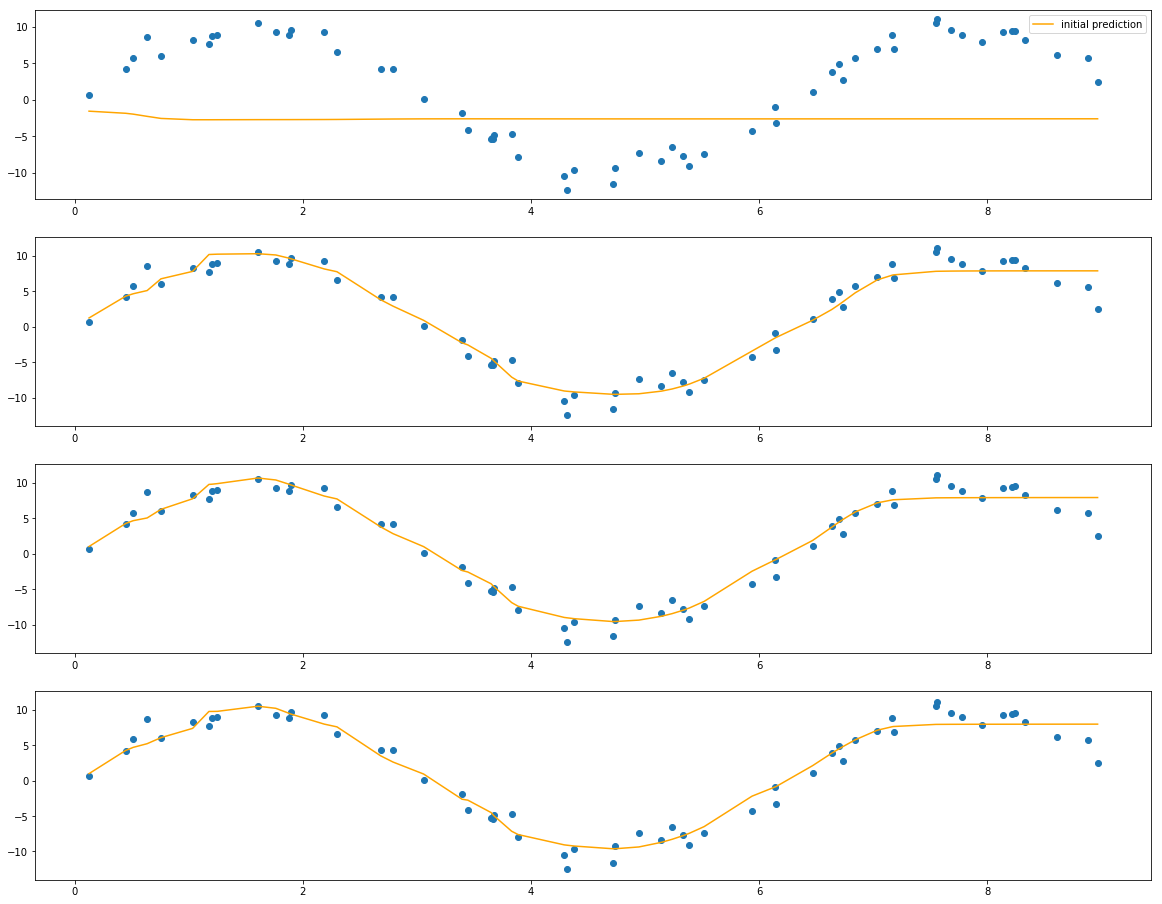

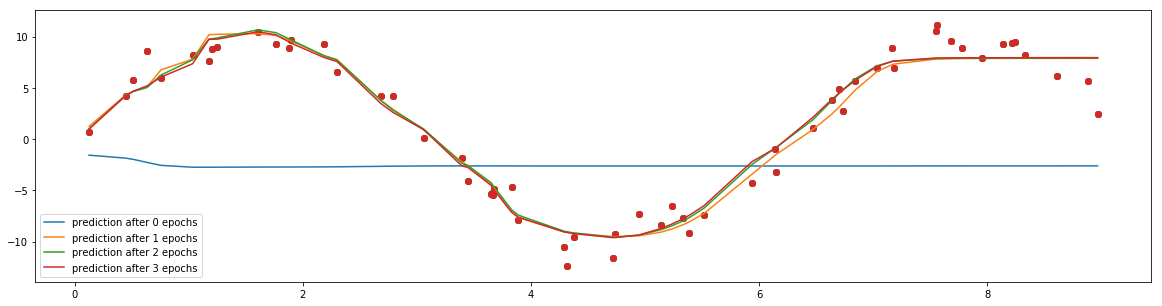

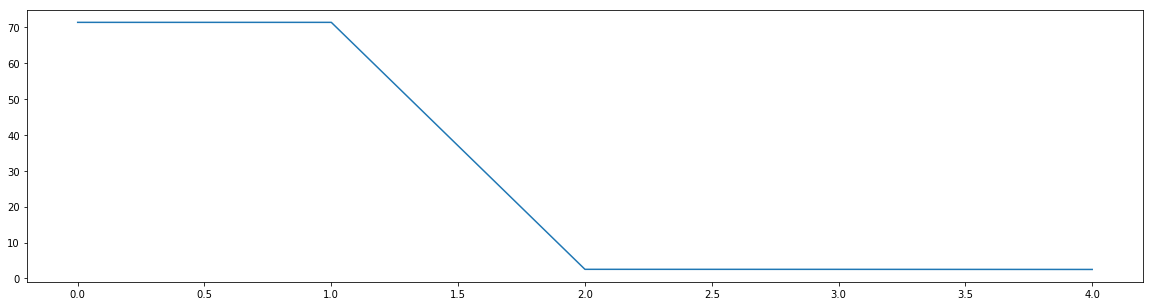

In [44]:
bill = BootstrapThroughTimeBobStrap()
visualisation.visualise(bill,dataset_creation.NonlinearDataset)

In [45]:
import visualisation 
importlib.reload(visualisation)

<module 'visualisation' from '/Users/thomas/Documents/Master-Thesis/new_version/visualisation.py'>

2 out of 10 predictors ready
3 out of 10 predictors ready
4 out of 10 predictors ready
5 out of 10 predictors ready
6 out of 10 predictors ready
7 out of 10 predictors ready
8 out of 10 predictors ready
9 out of 10 predictors ready
10 out of 10 predictors ready
1.0274394932888277e-15
5.493049223231279e-15
4.00405229457437e-15
3.2399958579968965e-15
2.6073551494119278e-15
2.1802900794953635e-15
1.882175572615832e-15
1.7325648756542737e-15
1.543308918410018e-15
1.3980870643680462e-15
4.424699533897291e-15
3.0434669677398294e-15
2.3357205477759798e-15
2.3978594251235056e-15
1.9537168532439044e-15
2.2967807723831177e-15
3.3114824595851758e-15
3.2058472677780383e-15
2.8915079702375634e-15
4.3075997351877434e-15


'this run of 10 epochs and 3 metaepochs took 1447.2741949558258s'

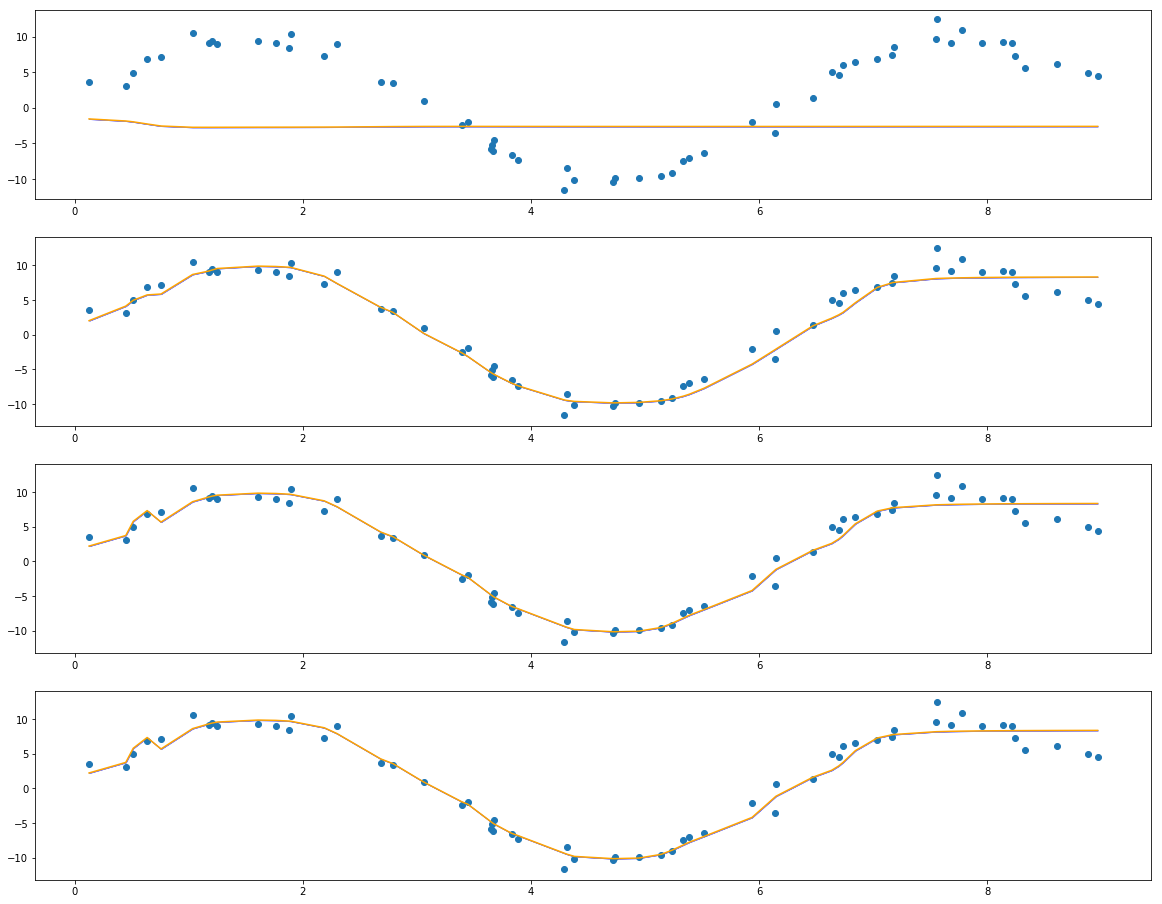

In [46]:
riker  = BootstrapThroughTimeBobStrap()

visualisation.visualise_uncertainty(riker,dataset_creation.NonlinearDataset)